# Import Libraries

In [1]:
!pip install --quiet tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 819 kB 5.3 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 121 kB 38.2 MB/s 
     |████████████████████████████████| 65.1 MB 75 kB/s 
     |████████████████████████████████| 4.0 MB 37.4 MB/s 
     |████████████████████████████████| 887 kB 43.4 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 238 kB 39.8 MB/s 
     |████████████████████████████████| 251 kB 50.1 MB/s 
     |████████████████████████████████| 126 kB 44.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.4.1 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
pymc 4.1.4 requires cachetools>=4.2.1, but you have cachetools 3.1.1 which is incompatible.
prophet 1.1 requires tqdm>=4.36.1, but you have tqdm 4.28.1 which is 

In [2]:
%load_ext tensorboard

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff



# SEED = 0
# tf.random.set_seed(SEED)
# np.random.seed(0)

tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

In [4]:
tf.__version__

'2.8.2'

In [5]:
tff.__version__

'0.20.0'

In [6]:
!python --version

Python 3.7.13


In [7]:
from tensorflow import keras
from keras.metrics import RootMeanSquaredError
from keras import layers
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError

from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt


import time


# Load data

In [8]:
path = "/content/drive/MyDrive/Thesis/Datasets/Pasteurizer_dataset/"

In [9]:
alice_df = pd.read_csv(path+ "federated/alice_set.csv")
bob_df = pd.read_csv(path+ "federated/bob_set.csv")

test_df = pd.read_csv(path+ "federated/test_set.csv")

In [10]:
alice_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,47,20,33.47,30.26,37.40,1,44.0188,30.47
1,47,30,37.40,30.47,38.69,1,43.9500,30.61
2,47,40,38.69,30.61,38.31,1,43.8500,30.85
3,47,50,38.31,30.85,37.73,1,43.7625,31.02
4,47,60,37.73,31.02,37.61,1,43.6813,31.27
...,...,...,...,...,...,...,...,...
23573,99,1830,36.03,38.43,36.32,6,35.2188,38.21
23574,99,1840,36.32,38.21,36.43,6,35.2438,38.04
23575,99,1850,36.43,38.04,36.43,6,35.1750,37.90
23576,99,1860,36.43,37.90,36.44,6,35.2313,37.78


In [11]:
bob_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,39,20,32.22,28.68,34.68,1,39.2062,28.70
1,39,30,34.68,28.70,35.78,1,39.0688,28.74
2,39,40,35.78,28.74,36.01,1,38.9875,28.80
3,39,50,36.01,28.80,36.60,1,38.8812,28.84
4,39,60,36.60,28.84,37.04,1,38.7687,28.92
...,...,...,...,...,...,...,...,...
23389,65,1790,36.80,38.80,36.96,6,35.9438,38.67
23390,65,1800,36.96,38.67,36.98,6,36.0000,38.53
23391,65,1810,36.98,38.53,36.97,6,36.0125,38.43
23392,65,1820,36.97,38.43,36.94,6,36.0812,38.36


In [12]:
test_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,214,20,36.25,28.00,38.71,1,44.0938,28.10
1,214,30,38.71,28.10,39.73,1,44.0000,28.27
2,214,40,39.73,28.27,40.57,1,43.9062,28.54
3,214,50,40.57,28.54,40.78,1,43.8187,28.80
4,214,60,40.78,28.80,41.36,1,43.7750,29.20
...,...,...,...,...,...,...,...,...
12173,149,2180,38.89,43.86,38.69,6,33.9562,43.46
12174,149,2190,38.69,43.46,38.64,6,33.9938,43.08
12175,149,2200,38.64,43.08,38.55,6,34.0563,42.69
12176,149,2210,38.55,42.69,38.31,6,34.1250,42.41


# Preparing Data

In [13]:
# Train test numpy arrays
X_alice = alice_df.drop(['curr_can_temp', 'prev_can_temp','paster_id'], axis=1).values
y_alice = alice_df['curr_can_temp'].values

X_bob = bob_df.drop(['curr_can_temp', 'prev_can_temp','paster_id'], axis=1).values
y_bob = bob_df['curr_can_temp'].values


X_test = test_df.drop(['curr_can_temp', 'prev_can_temp','paster_id'], axis=1).values
y_test = test_df['curr_can_temp'].values

In [14]:
# Min max normalizaiton

min_max_scaler = preprocessing.MinMaxScaler()

X_alice = min_max_scaler.fit_transform(X_alice)
X_bob = min_max_scaler.fit_transform(X_bob)
X_test = min_max_scaler.fit_transform(X_test)


In [15]:
y_alice.shape

(23578,)

In [16]:
X_test.shape

(12178, 5)

In [17]:
y_alice.shape

(23578,)

In [18]:
y_alice = y_alice.reshape(y_alice.shape[0],1)
y_bob = y_bob.reshape(y_bob.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

In [19]:
y_alice.shape

(23578, 1)

# Hyperparameters

In [20]:
# BATCH_SIZE = 16
# GLOBAL_EPOCHS = 10
# LOCAL_EPOCHS = 25

BATCH_SIZE = 16
GLOBAL_EPOCHS = 15
LOCAL_EPOCHS = 25

# Federated Dataset

In [21]:
# Use 80% for training and 20% for validation
alice_split = round(X_alice.shape[0] * 0.8)
bob_split = round(X_bob.shape[0] * 0.8)

In [22]:
train_data, test_data, val_data = [], [], []

temp_dataset = tf.data.Dataset.from_tensor_slices((X_alice[:alice_split], y_alice[:alice_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)
temp_dataset = tf.data.Dataset.from_tensor_slices((X_bob[:bob_split], y_bob[:bob_split])).repeat(LOCAL_EPOCHS).batch(BATCH_SIZE)
train_data.append(temp_dataset)


temp_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data.append(temp_dataset.batch(1))

X_val = np.concatenate([X_alice[alice_split:],X_bob[bob_split:]])
y_val = np.concatenate([y_alice[alice_split:],y_bob[bob_split:]])

temp_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_data.append(temp_dataset.batch(BATCH_SIZE))

In [23]:
train_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>]

In [24]:
val_data

[<BatchDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>]

# Create Model

In [25]:
def input_spec():
    return (
        tf.TensorSpec([None, 5], tf.float64),
        tf.TensorSpec([None, 1], tf.float64)
    )

def model_fn(centralized=False):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(5,)),                                       
        tf.keras.layers.Dense(20, activation='relu', kernel_regularizer='l1_l2'),
        tf.keras.layers.Dense(1, activation='relu'),
    ])

    if centralized:
      return model
    else:
      return tff.learning.from_keras_model(
          model,
          input_spec=input_spec(),
          loss=tf.keras.losses.MeanSquaredError(),
          metrics=[MeanAbsoluteError(),RootMeanSquaredError(), MeanSquaredError()])

# Training

In [26]:
trainer = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.Adam(),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = 1)
)

In [27]:
# creating the directory and the corresponding summary writer to write the metrics to

#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = trainer.initialize()

In [28]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [29]:


state = trainer.initialize()
train_hist = []

losses = []
mae = []

val_losses = []
val_mae = []


start = time.time()
with summary_writer.as_default():
  for round_num in range(GLOBAL_EPOCHS):
      state, metrics = trainer.next(state, train_data)
      for name, value in metrics['train'].items():
        tf.summary.scalar(name, value, step=round_num)

      train_hist.append(metrics)

      losses.append(metrics['train']['loss'])
      mae.append(metrics['train']['mean_absolute_error'])


      val_metrics = evaluator(state.model, val_data)
      val_losses.append(val_metrics['eval']['loss'])
      val_mae.append(val_metrics['eval']['mean_absolute_error'])

      print(f"\rRun {round_num+1}/{GLOBAL_EPOCHS}    ", end="")
      print("loss(mse): {loss} MAE: {mae}".format(mae = metrics["train"]['mean_absolute_error'], loss = metrics["train"]['loss']))
end = time.time()
print(f"Training time {end - start:.2f} sec")

Run 1/15    loss(mse): 46.93315124511719 MAE: 2.893436908721924
Run 2/15    loss(mse): 7.9769110679626465 MAE: 1.9373044967651367
Run 3/15    loss(mse): 7.696145534515381 MAE: 1.8715330362319946
Run 4/15    loss(mse): 7.527344703674316 MAE: 1.8284454345703125
Run 5/15    loss(mse): 7.425787925720215 MAE: 1.8036675453186035
Run 6/15    loss(mse): 7.357192039489746 MAE: 1.7885568141937256
Run 7/15    loss(mse): 7.305629730224609 MAE: 1.778134822845459
Run 8/15    loss(mse): 7.263607025146484 MAE: 1.770039439201355
Run 9/15    loss(mse): 7.227405071258545 MAE: 1.7631604671478271
Run 10/15    loss(mse): 7.1960039138793945 MAE: 1.7572739124298096
Run 11/15    loss(mse): 7.168670177459717 MAE: 1.7522135972976685
Run 12/15    loss(mse): 7.144986629486084 MAE: 1.747849702835083
Run 13/15    loss(mse): 7.124449729919434 MAE: 1.7441009283065796
Run 14/15    loss(mse): 7.106491565704346 MAE: 1.7408521175384521
Run 15/15    loss(mse): 7.090860843658447 MAE: 1.7379956245422363
Training time 276.28 

In [30]:
metrics['train']

OrderedDict([('mean_absolute_error', 1.7379956),
             ('root_mean_squared_error', 2.662867),
             ('mean_squared_error', 7.090861),
             ('loss', 7.090861),
             ('num_examples', 939425),
             ('num_batches', 58715)])

In [31]:
val_mae

[1.9757316,
 1.848034,
 1.7796124,
 1.7378907,
 1.7094418,
 1.687097,
 1.6676767,
 1.6487978,
 1.6313242,
 1.6153069,
 1.6006116,
 1.5873536,
 1.5754861,
 1.5648272,
 1.5552361]

In [32]:

federated_metrics = evaluator(state.model, train_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 1.7765665),
                           ('root_mean_squared_error', 2.7330244),
                           ('mean_squared_error', 7.4694223),
                           ('loss', 7.4694223),
                           ('num_examples', 939425),
                           ('num_batches', 58715)]))])

In [33]:

federated_metrics = evaluator(state.model, test_data)
federated_metrics

OrderedDict([('eval',
              OrderedDict([('mean_absolute_error', 1.9056427),
                           ('root_mean_squared_error', 2.6186657),
                           ('mean_squared_error', 6.8574104),
                           ('loss', 6.8574104),
                           ('num_examples', 12178),
                           ('num_batches', 12178)]))])

# Plot

In [34]:
evaluator = tff.learning.build_federated_evaluation(model_fn)

In [35]:
def plot(train, valid, name):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(train)+1), train, label='train')
    plt.plot(range(1, len(valid)+1), valid, label='validate')
    plt.xlabel('Rounds')
    plt.ylabel(name)
    plt.legend()
    plt.show()

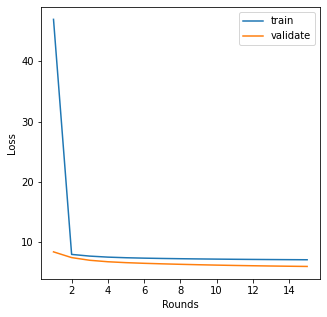

In [36]:
plot(losses, val_losses, 'Loss')

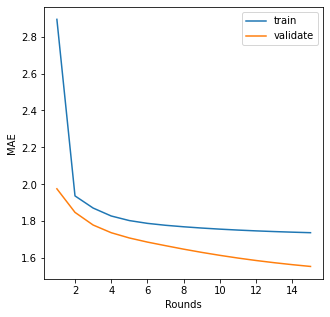

In [37]:
plot(mae,val_mae,"MAE")

In [38]:
# #@test {"skip": true}
# !ls {logdir}
# %tensorboard --logdir {logdir} --port=0

# Evaluation

In [39]:
centralized_model = model_fn(centralized=True)

In [40]:
# centralized_model.get_weights()

In [41]:
# Compile a centralized model with the federated weights

centralized_model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[MeanAbsoluteError(),RootMeanSquaredError(), MeanSquaredError()])
state.model.assign_weights_to(centralized_model)

In [42]:
def evaluate(y_true, y_hat, label='test'):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = mean_squared_error(y_true, y_hat, squared=False)
    variance = r2_score(y_true, y_hat)
    print('{} set: MAE:{} RMSE:{}, MSE:{}, R2:{}'.format(label,mae, rmse, mse, variance))

In [43]:
X_train_only = np.concatenate((X_alice[:alice_split], X_bob[:bob_split]), axis=0)
y_train_only = np.concatenate((y_alice[:alice_split], y_bob[:bob_split]), axis=0)

In [44]:
# X_alice[:alice_split], y_alice[:alice_split]

# y_hat_train = centralized_model.predict(X_alice[:alice_split])
# evaluate(y_alice[:alice_split], y_hat_train)

In [45]:
# y_hat_train = centralized_model.predict(X_bob[:bob_split])
# evaluate(y_bob[:bob_split], y_hat_train)

In [46]:
y_hat_train_only = centralized_model.predict(X_train_only)
evaluate(y_train_only, y_hat_train_only, label='train')

train set: MAE:1.7765641161618684 RMSE:2.7330220064813617, MSE:7.469409287911409, R2:0.916962486789199


In [47]:
y_hat_test = centralized_model.predict(X_test)
evaluate(y_test, y_hat_test)

test set: MAE:1.9056477416538609 RMSE:2.6186650875830866, MSE:6.857406840926535, R2:0.9254772216051712


In [48]:
y_hat_test

array([[27.585093],
       [29.399223],
       [30.268414],
       ...,
       [43.841805],
       [43.798927],
       [43.657173]], dtype=float32)

In [49]:
y_test

array([[28.1 ],
       [28.27],
       [28.54],
       ...,
       [42.69],
       [42.41],
       [42.17]])

# Temp Plots

In [50]:
test_df

,paster_id,paster_timeslot,prev_water_temp,prev_can_temp,curr_water_temp,bath_number,curr_bath_temp,curr_can_temp
0,214,20,36.25,28.00,38.71,1,44.0938,28.10
1,214,30,38.71,28.10,39.73,1,44.0000,28.27
2,214,40,39.73,28.27,40.57,1,43.9062,28.54
3,214,50,40.57,28.54,40.78,1,43.8187,28.80
4,214,60,40.78,28.80,41.36,1,43.7750,29.20
...,...,...,...,...,...,...,...,...
12173,149,2180,38.89,43.86,38.69,6,33.9562,43.46
12174,149,2190,38.69,43.46,38.64,6,33.9938,43.08
12175,149,2200,38.64,43.08,38.55,6,34.0563,42.69
12176,149,2210,38.55,42.69,38.31,6,34.1250,42.41


In [51]:
test_ids = list(pd.unique(test_df.paster_id))
# test_ids


In [52]:
X_test_list = []
y_test_list = []

In [53]:
for id in test_ids:
  my_df = test_df.loc[ test_df.paster_id == id ]
  X_test_list.append(min_max_scaler.fit_transform(my_df.drop(['curr_can_temp', 'prev_can_temp','paster_id'], axis=1).values))
  y_test_list.append(my_df['curr_can_temp'].values)

In [54]:
my_df = test_df.loc[ test_df.paster_id == id ]

In [55]:
# X_test_0 = min_max_scaler.fit_transform(my_df.drop(['curr_can_temp','paster_id'], axis=1).values)

In [56]:
# y_test_0 = my_df['curr_can_temp'].values

In [57]:
pred_list = []
for x in X_test_list:
  pred_list.append(centralized_model.predict(x))

In [58]:
# 7,8,9,10,16,18,33, !!37!!, 38!, 47!

In [59]:
def my_plot(true, prediction):
  line_thickness = 5
  plt.clf()
  plt.figure(figsize=(8,8))
  plt.plot(range(1, len(true)+1), true, label='true', linewidth=line_thickness, c='g')
  plt.plot(range(1, len(prediction)+1), prediction, label='predicted', linewidth=line_thickness, c='r')


  plt.xlabel('cycles')
  plt.ylabel('temperature(celcius)')
  plt.legend()
  plt.show()


<Figure size 432x288 with 0 Axes>

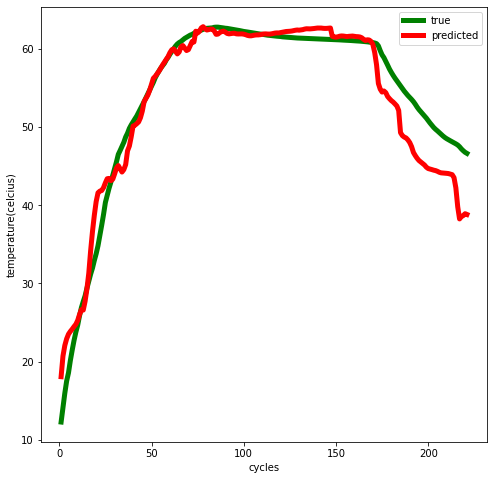

In [60]:
pos = 37
my_plot(y_test_list[pos] , pred_list[pos])

0


<Figure size 432x288 with 0 Axes>

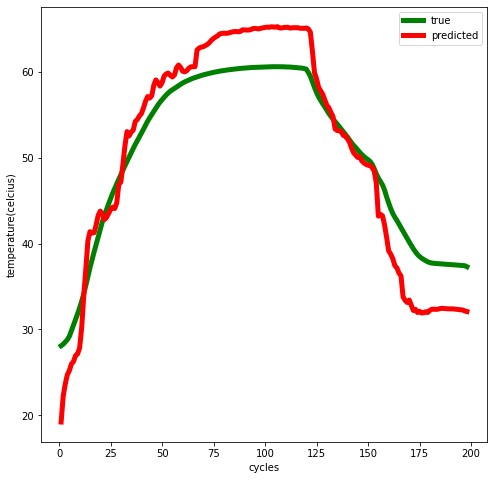

1


<Figure size 432x288 with 0 Axes>

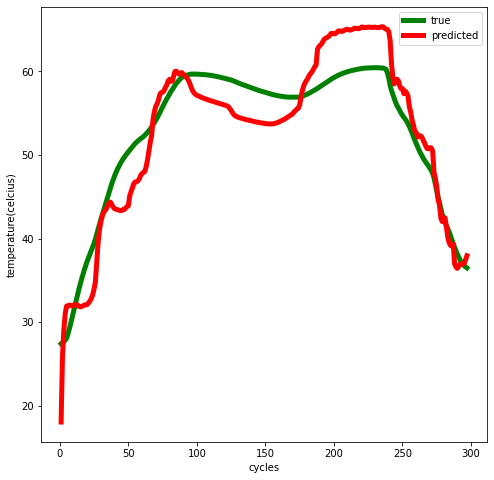

2


<Figure size 432x288 with 0 Axes>

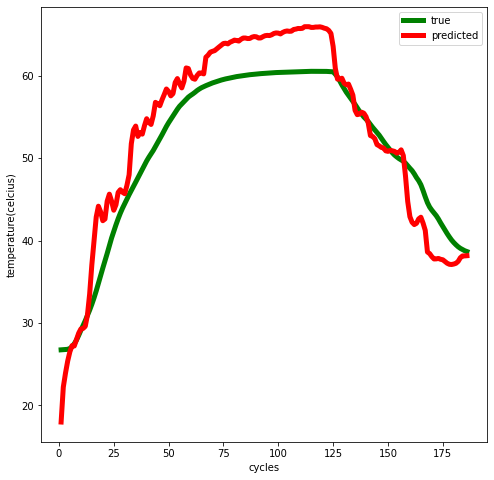

3


<Figure size 432x288 with 0 Axes>

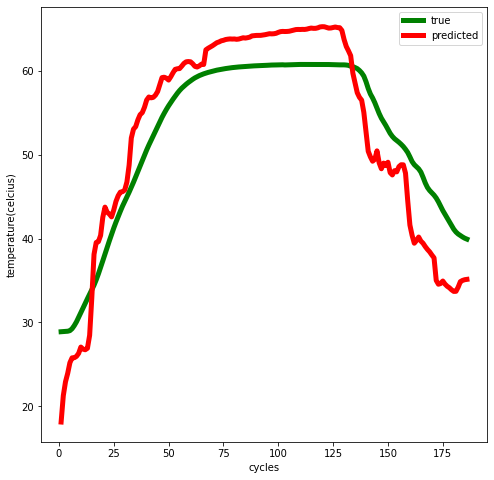

4


<Figure size 432x288 with 0 Axes>

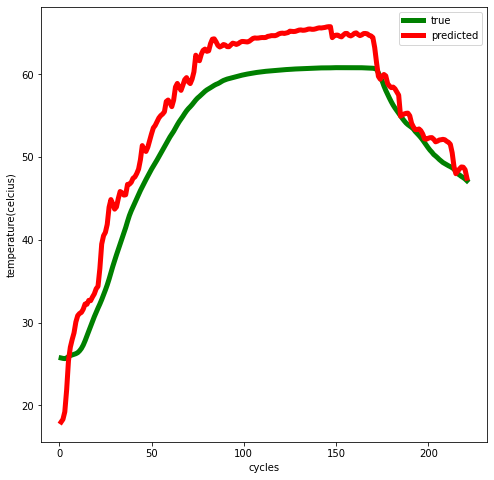

5


<Figure size 432x288 with 0 Axes>

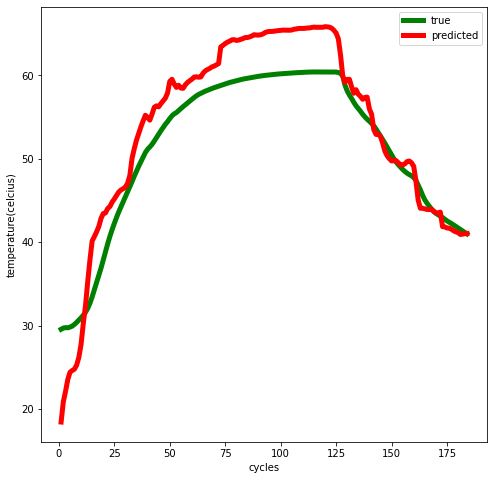

6


<Figure size 432x288 with 0 Axes>

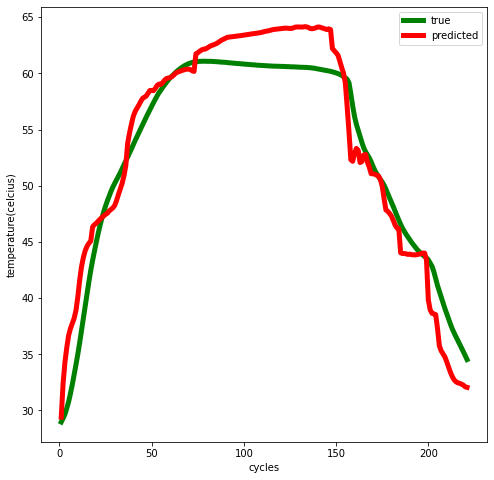

7


<Figure size 432x288 with 0 Axes>

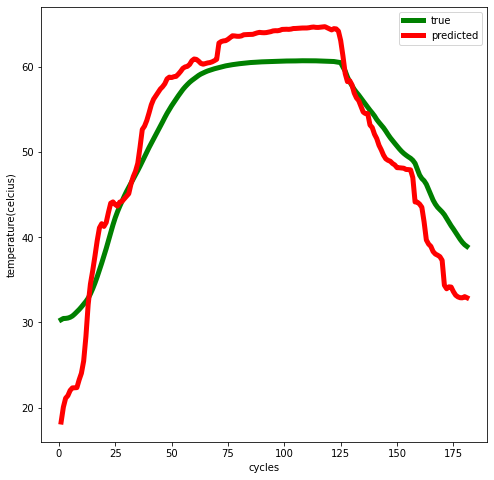

8


<Figure size 432x288 with 0 Axes>

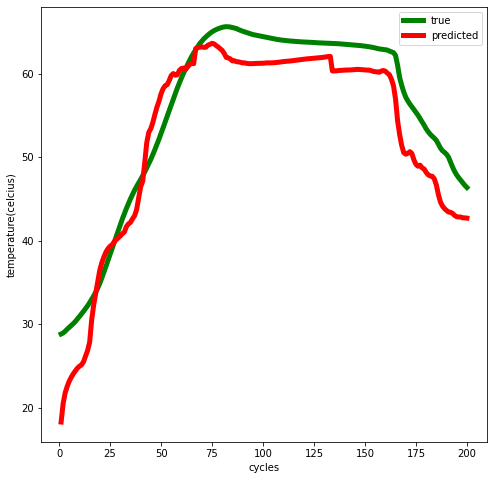

9


<Figure size 432x288 with 0 Axes>

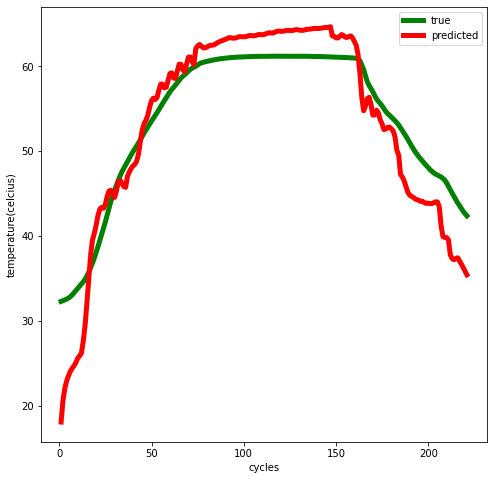

10


<Figure size 432x288 with 0 Axes>

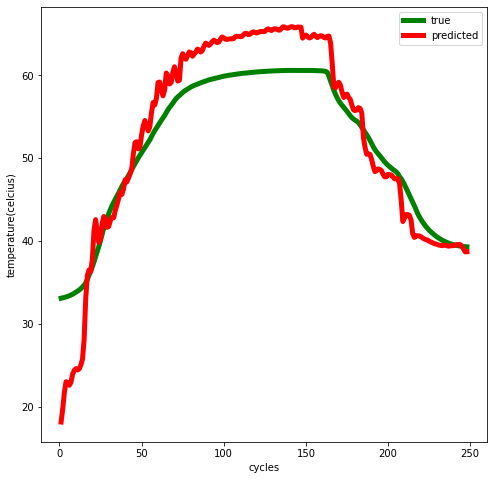

11


<Figure size 432x288 with 0 Axes>

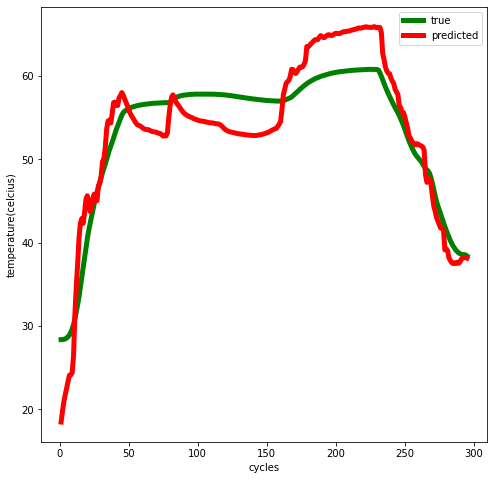

12


<Figure size 432x288 with 0 Axes>

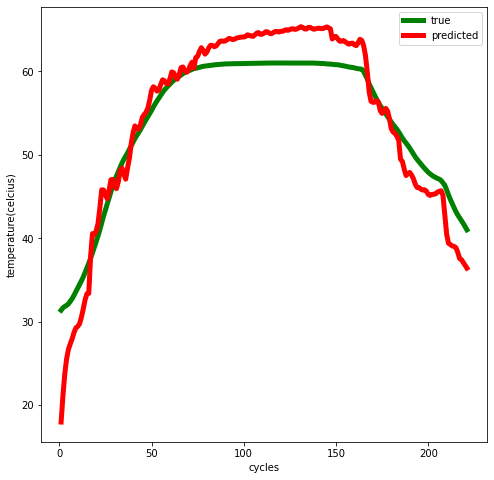

13


<Figure size 432x288 with 0 Axes>

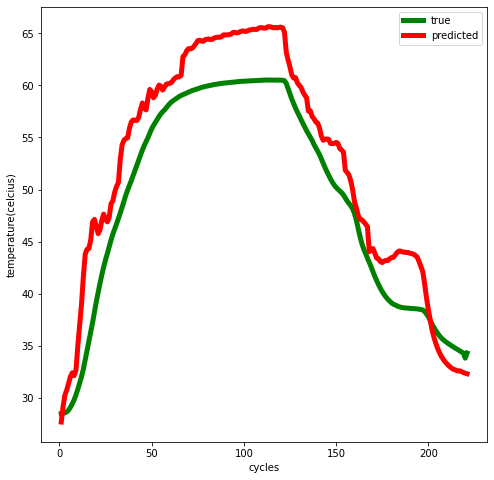

14


<Figure size 432x288 with 0 Axes>

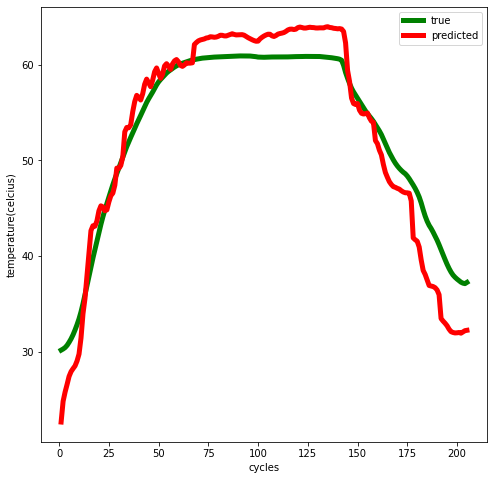

15


<Figure size 432x288 with 0 Axes>

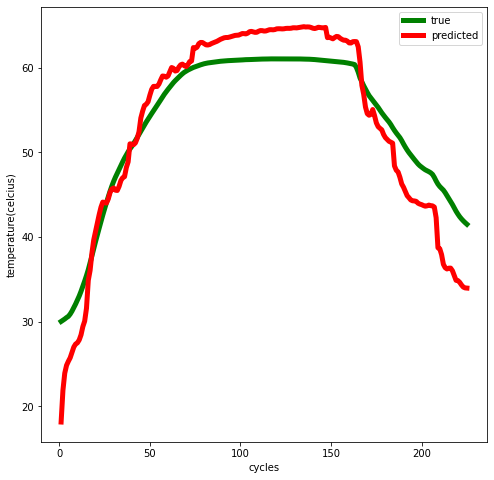

16


<Figure size 432x288 with 0 Axes>

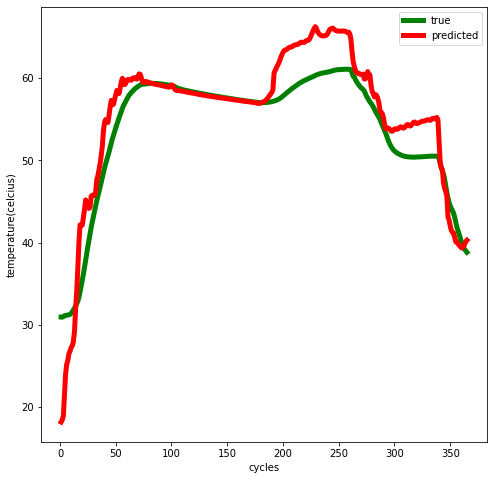

17


<Figure size 432x288 with 0 Axes>

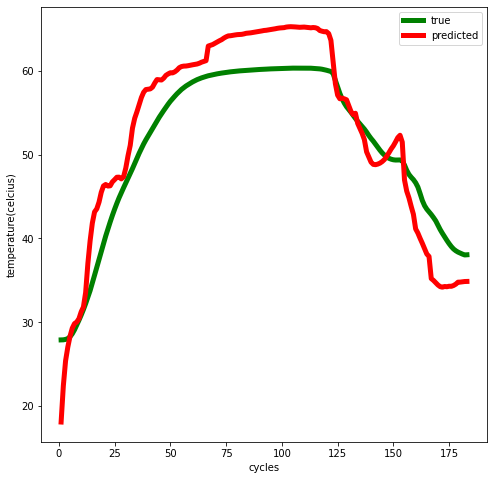

18


<Figure size 432x288 with 0 Axes>

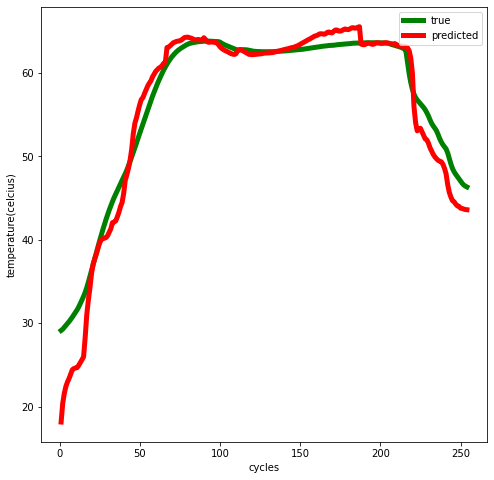

19


<Figure size 432x288 with 0 Axes>

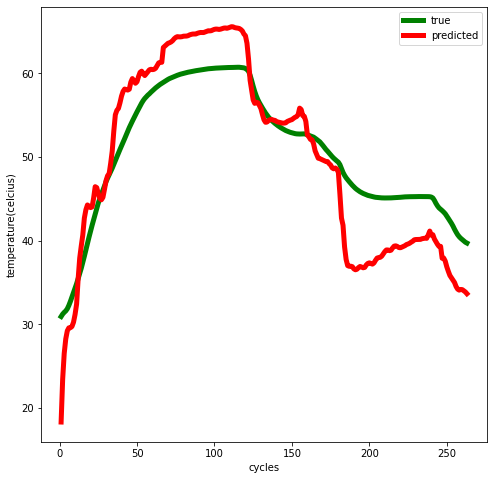

20


<Figure size 432x288 with 0 Axes>

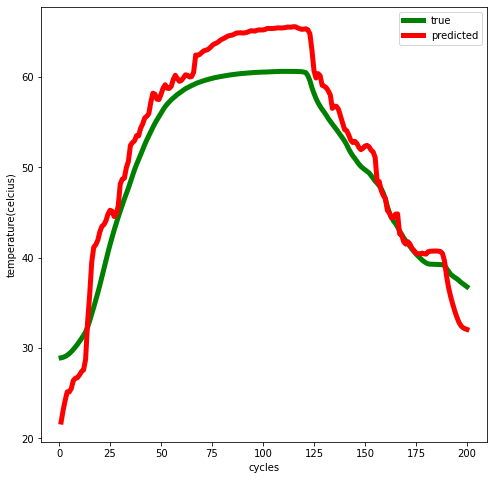

21


<Figure size 432x288 with 0 Axes>

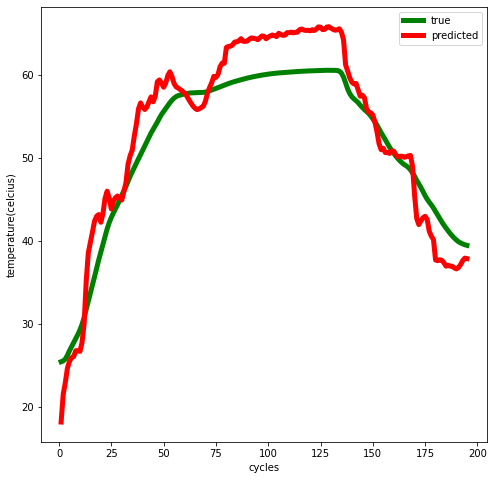

22


<Figure size 432x288 with 0 Axes>

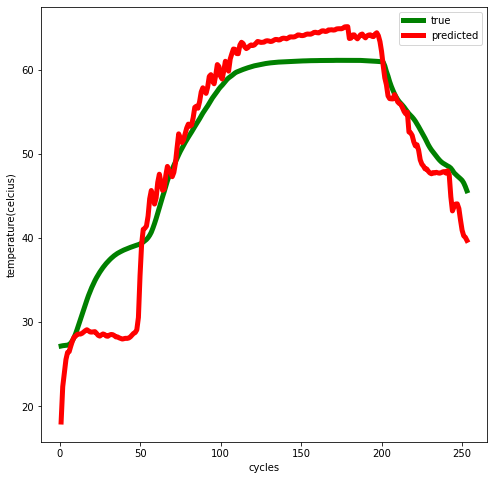

23


<Figure size 432x288 with 0 Axes>

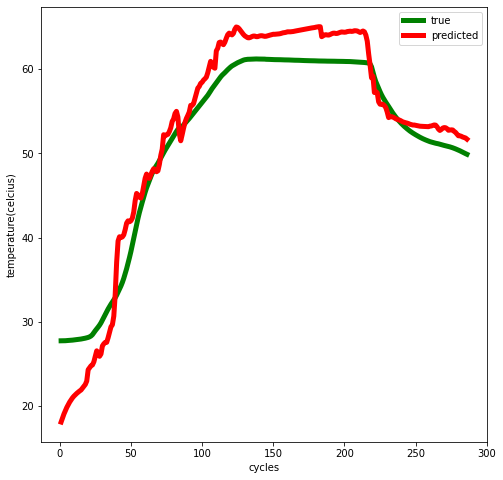

24


<Figure size 432x288 with 0 Axes>

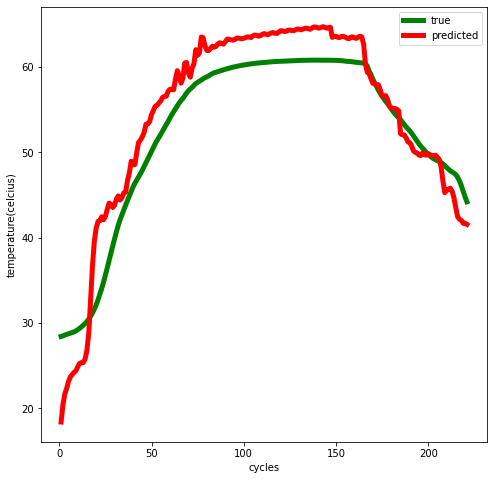

25


<Figure size 432x288 with 0 Axes>

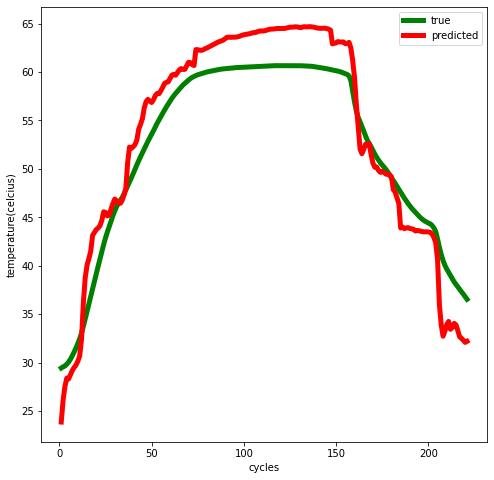

26


<Figure size 432x288 with 0 Axes>

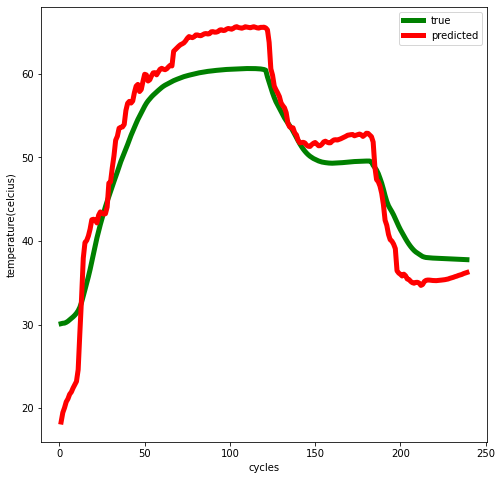

27


<Figure size 432x288 with 0 Axes>

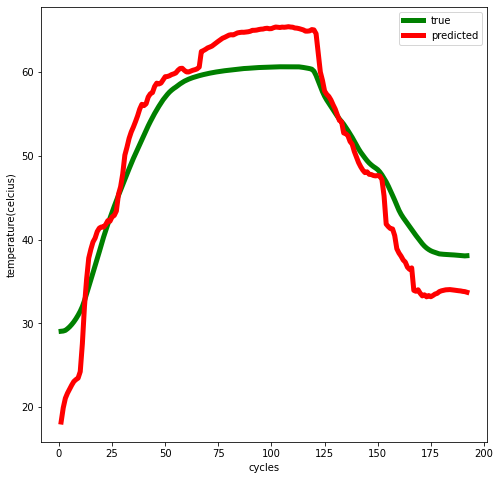

28


<Figure size 432x288 with 0 Axes>

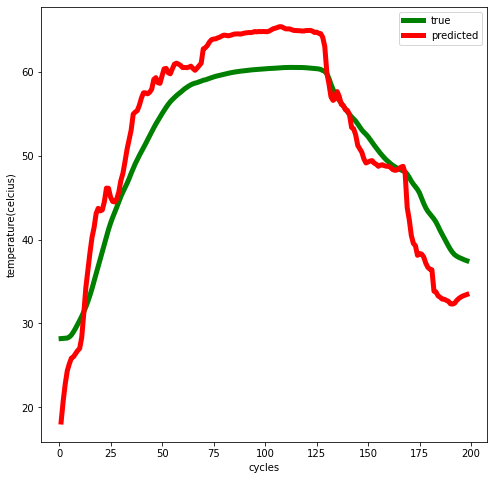

29


<Figure size 432x288 with 0 Axes>

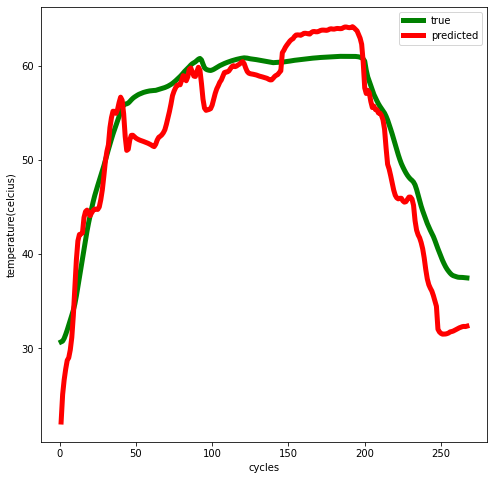

30


<Figure size 432x288 with 0 Axes>

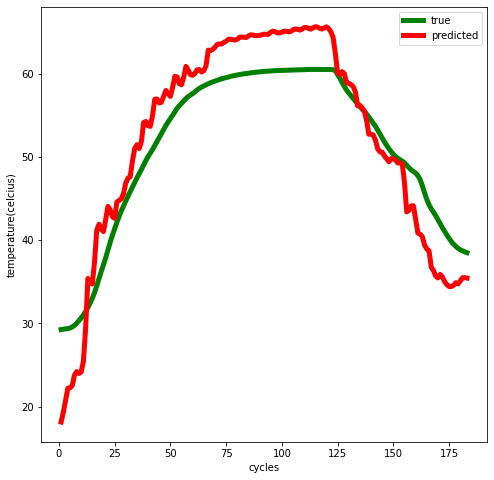

31


<Figure size 432x288 with 0 Axes>

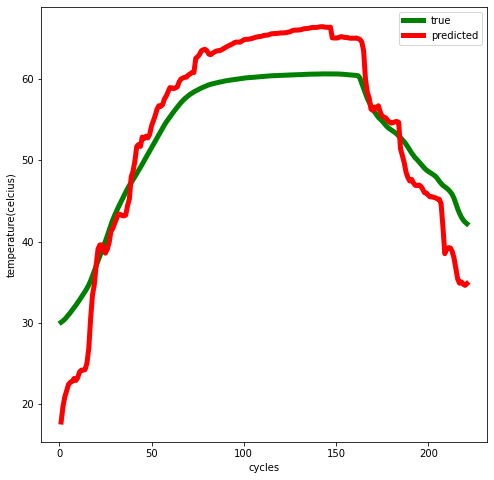

32


<Figure size 432x288 with 0 Axes>

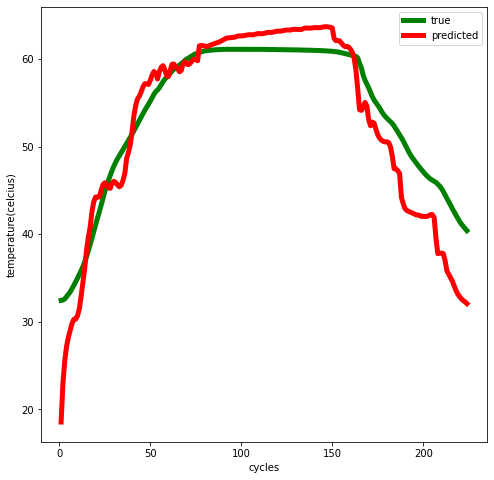

33


<Figure size 432x288 with 0 Axes>

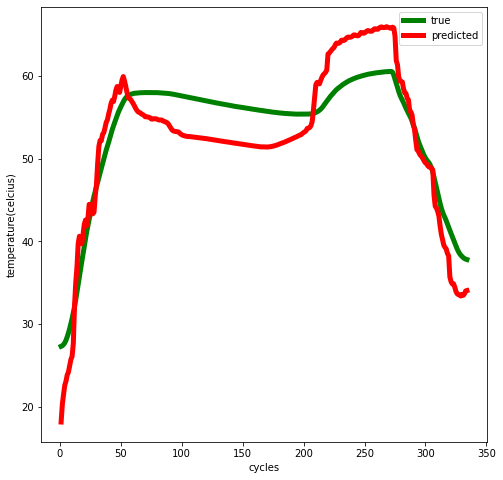

34


<Figure size 432x288 with 0 Axes>

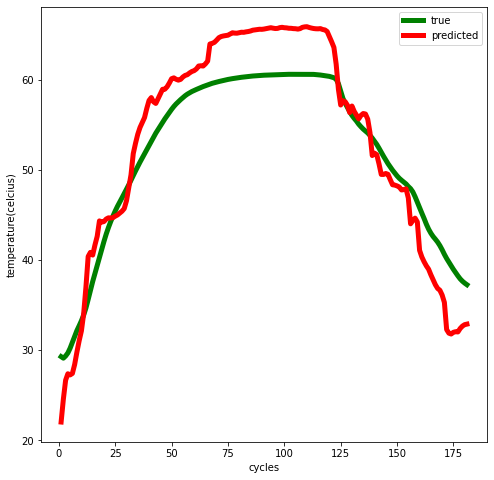

35


<Figure size 432x288 with 0 Axes>

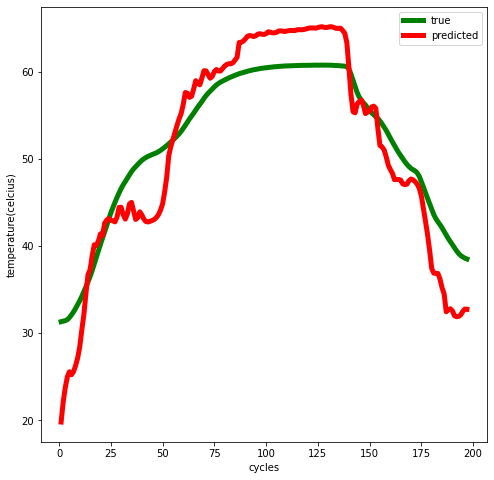

36


<Figure size 432x288 with 0 Axes>

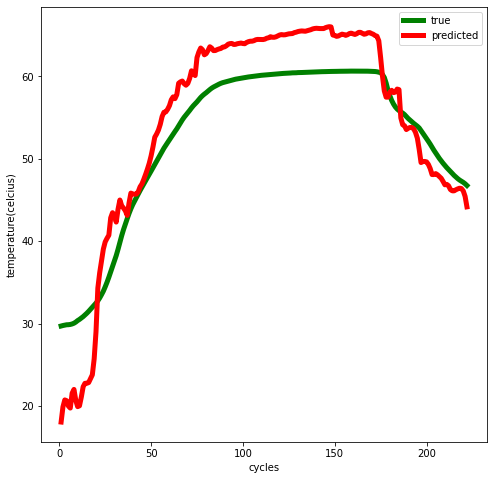

37


<Figure size 432x288 with 0 Axes>

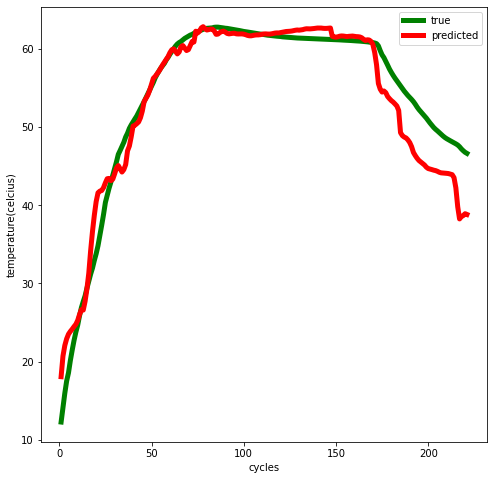

38


<Figure size 432x288 with 0 Axes>

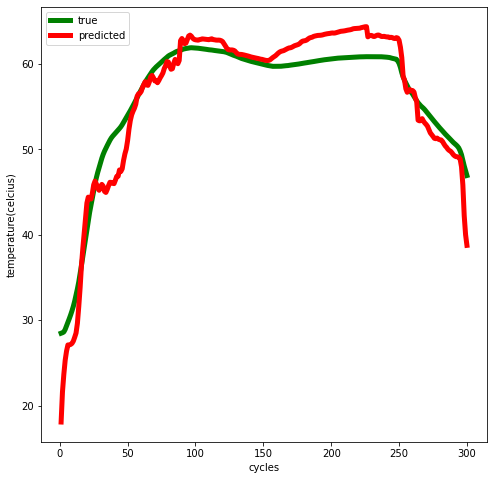

39


<Figure size 432x288 with 0 Axes>

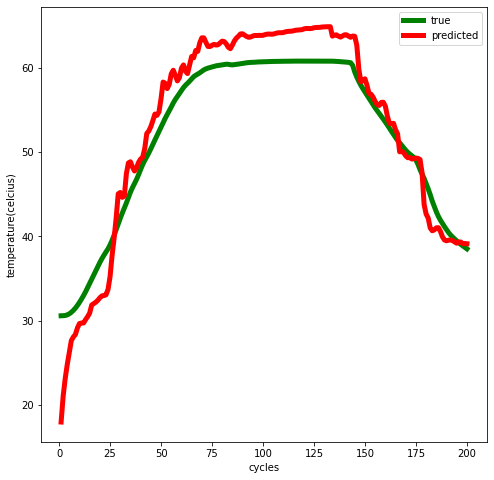

40


<Figure size 432x288 with 0 Axes>

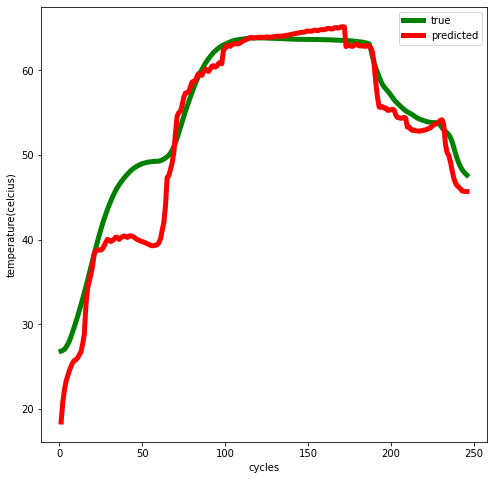

41


<Figure size 432x288 with 0 Axes>

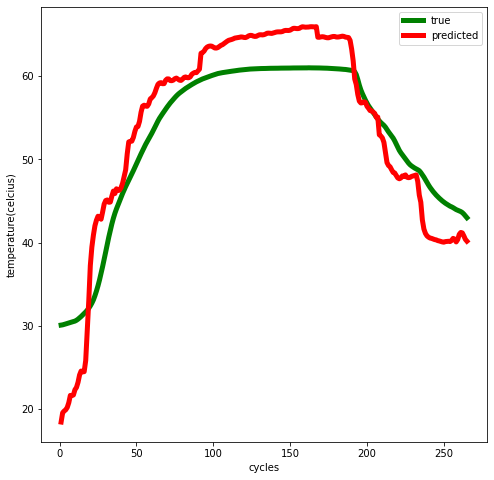

42


<Figure size 432x288 with 0 Axes>

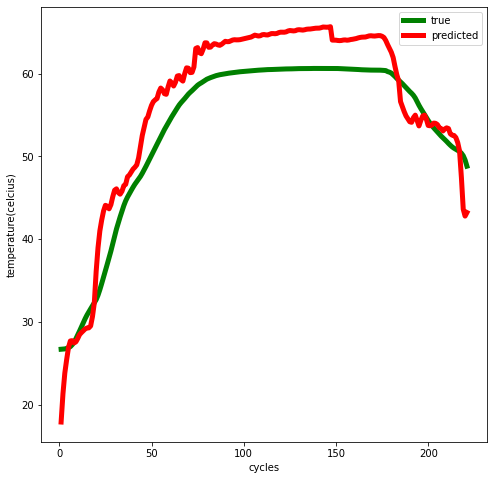

43


<Figure size 432x288 with 0 Axes>

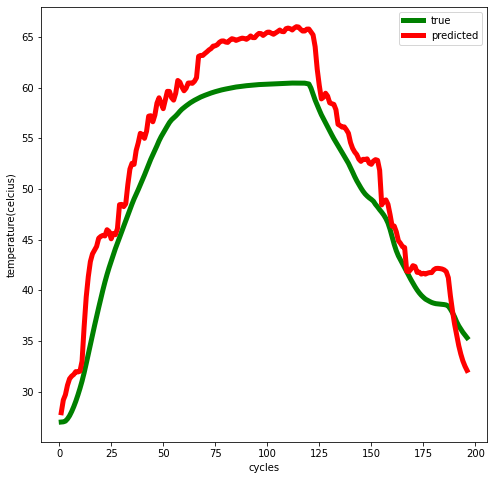

44


<Figure size 432x288 with 0 Axes>

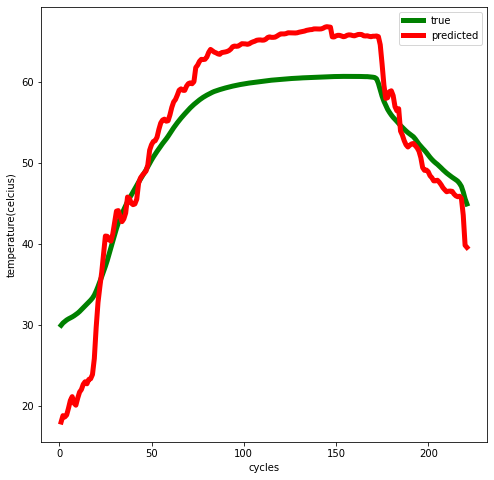

45


<Figure size 432x288 with 0 Axes>

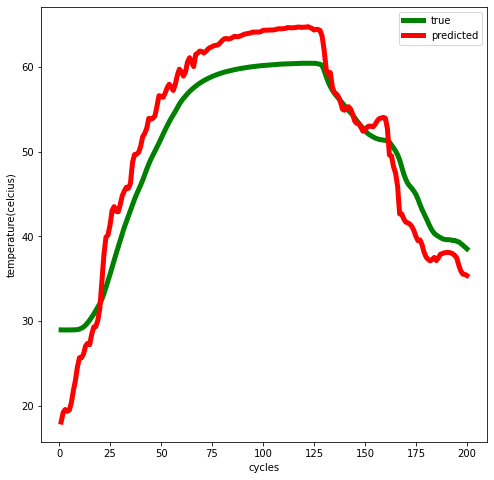

46


<Figure size 432x288 with 0 Axes>

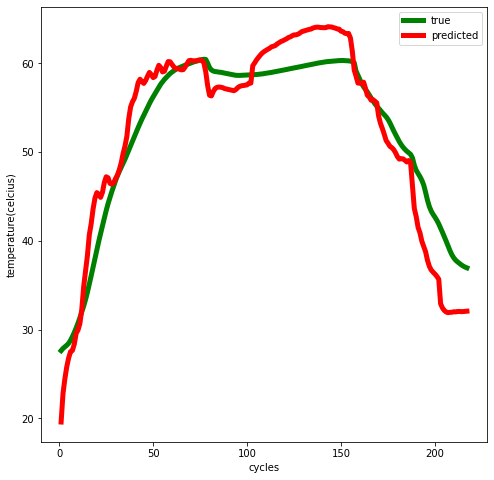

47


<Figure size 432x288 with 0 Axes>

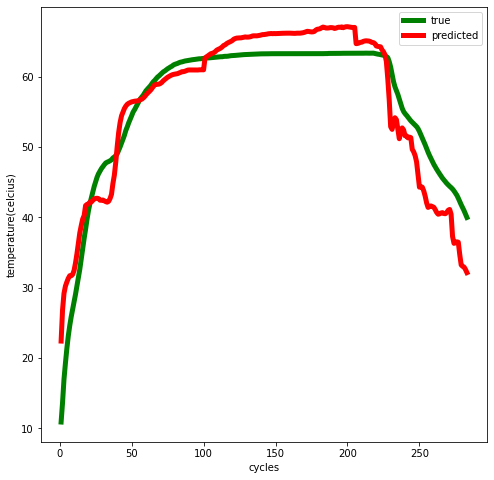

48


<Figure size 432x288 with 0 Axes>

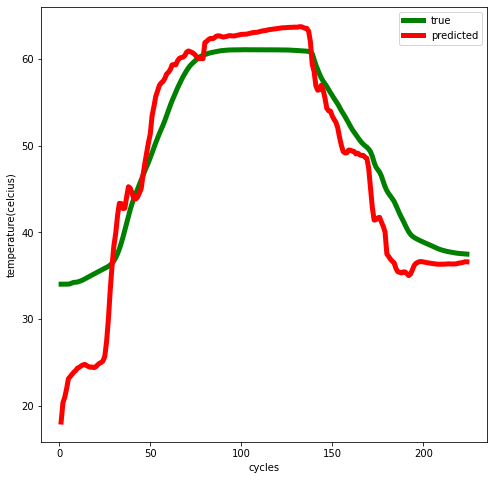

49


<Figure size 432x288 with 0 Axes>

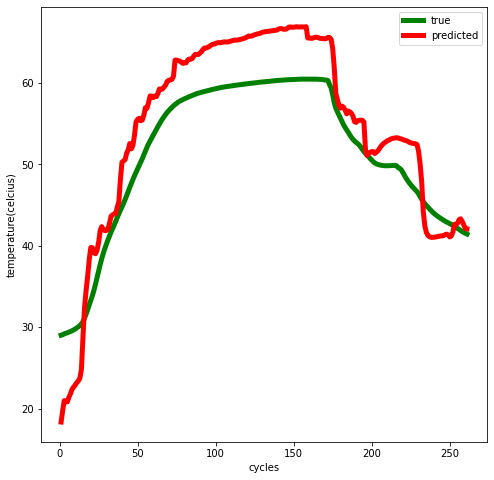

50


<Figure size 432x288 with 0 Axes>

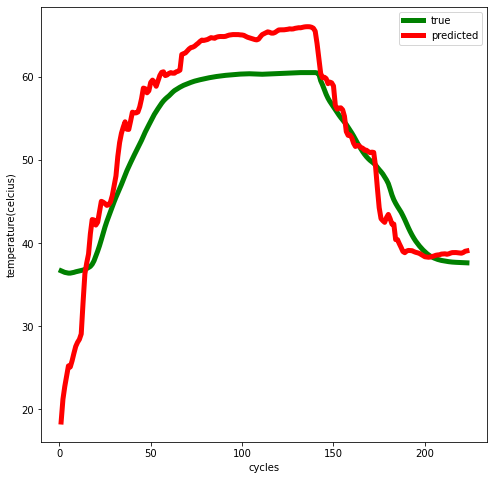

51


<Figure size 432x288 with 0 Axes>

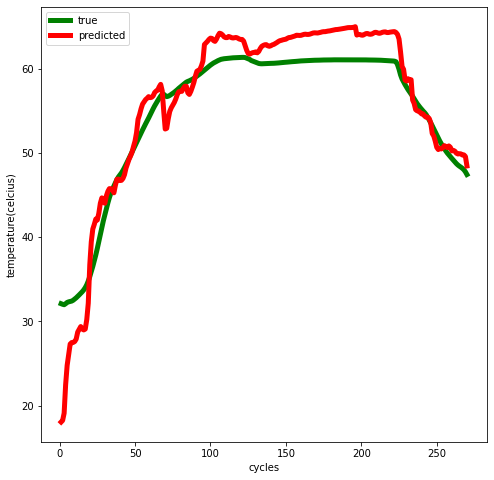

52


<Figure size 432x288 with 0 Axes>

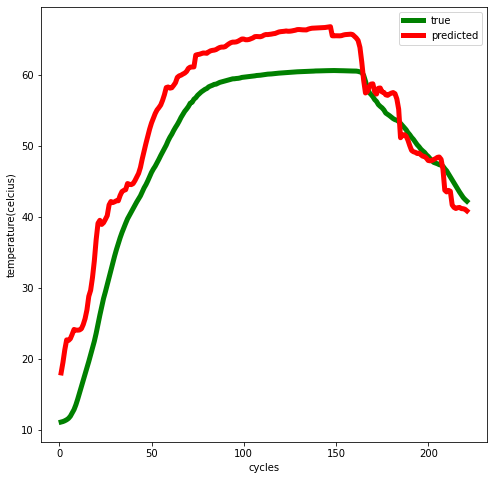

In [61]:
# plot all predictions
for i in range(len(y_test_list)):
  print(i)
  my_plot(y_test_list[i],pred_list[i])